# Predicting Restaurant Annual Turnover in India

The first thing any visitor to India will take in — probably while staring out the window in awe as their aeroplane descends — is the sheer size of this country. It is densely populated and patch-worked with distinct neighbourhoods, each with its own culinary identity. It would take several lifetimes to get to know all of the street stands, holes in the wall, neighbourhood favourites, and high-end destinations in this city.

## The Joy of Dining Out in India

For Indians, dining out is and always will be a joyous occasion. Everyone has their own favourite restaurants in the city, starting from the street food stall across the street to the 5-star restaurants in the heart of the city. Some are favourites because of the memories attached to them, and some are favourites because of the fantastic ambience. There are many other factors that contribute to the popularity of these restaurants.

## The Business Perspective

From a business perspective, the popularity of a restaurant is crucial. Higher popularity often means more visits to the restaurant, which leads to increased annual turnover. For a restaurant to thrive and continue operating, it must maintain a substantial annual turnover.

## The Problem: Predicting Annual Turnover

This problem aims to predict the annual turnover of a set of restaurants across India based on various factors. The dataset includes several key variables such as:

- **Restaurant-specific data**: Location, opening date, cuisine type, themes, etc.
- **External data**: Social media popularity index, Zomato ratings, and other external metrics.
- **Customer insights**: Survey data from customers and ratings from mystery visitors (third-party audits).

By analyzing these variables, we can gain insights into the factors that influence a restaurant's success and predict its annual turnover.


In [699]:
! pip install lightgbm

In [700]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb

warnings.simplefilter("ignore")
#
import statsmodels.api as sm
# to compute VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso,Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from statsmodels.tools.tools import add_constant
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Set pandas display option to avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', None)


In [701]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [702]:
path='/content/drive/MyDrive/Python Course'

### Utility

In [703]:
def calculate_group_percentage(df, group_by_columns):
    """
    Calculate count and percentage of occurrences for grouped data in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        group_by_columns (list or str): The column(s) to group by.

    Returns:
        pd.DataFrame: A DataFrame with count and percentage for each group.
    """
    # Group by specified columns and calculate counts
    group_counts = df.groupby(group_by_columns).size()

    # Convert counts to a DataFrame
    result_df = group_counts.to_frame(name='Count')

    # Calculate percentages
    result_df['Percentage'] = (result_df['Count'] / result_df['Count'].sum()) * 100

    # Reset index for easier readability
    result_df = result_df.reset_index().sort_values(by='Count', ascending=False)

    return result_df

In [704]:
def calculate_group_percentage_with_others(df, group_by_column, threshold=5.0, others_label="Others"):
    """
    Calculate count and percentage of occurrences for grouped data in a DataFrame,
    group smaller values into an "Others" category, update the original DataFrame,
    and return a mapping dictionary for consistent grouping in test data.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        group_by_column (str): The column to group by.
        threshold (float): The percentage threshold below which groups are categorized as "Others".
        others_label (str): The label to assign to grouped smaller categories.

    Returns:
        pd.DataFrame: A DataFrame with count and percentage, including the "Others" category.
        pd.DataFrame: The original DataFrame with the grouped column updated.
        dict: A mapping dictionary for replacing categories in test data.
    """
    # Group by specified column and calculate counts
    group_counts = df.groupby(group_by_column).size()

    # Convert counts to a DataFrame
    result_df = group_counts.to_frame(name='Count')

    # Calculate percentages
    result_df['Percentage'] = (result_df['Count'] / result_df['Count'].sum()) * 100

    # Identify groups below the threshold
    small_groups = result_df[result_df['Percentage'] < threshold].index.tolist()

    # Create a mapping dictionary
    mapping_dict = {category: others_label if category in small_groups else category for category in result_df.index}

    # Update the original DataFrame using the mapping dictionary
    df[group_by_column] = df[group_by_column].map(mapping_dict)

    # Recalculate group counts and percentages after updating the original DataFrame
    updated_group_counts = df.groupby(group_by_column).size()
    updated_result_df = updated_group_counts.to_frame(name='Count')
    updated_result_df['Percentage'] = (updated_result_df['Count'] / updated_result_df['Count'].sum()) * 100

    # Reset index for easier readability
    updated_result_df = updated_result_df.reset_index().sort_values(by='Count', ascending=False)

    return updated_result_df, df, mapping_dict


In [705]:
def group_by_turnover_impact(df, group_by_column, turnover_column='Annual Turnover', threshold=5.0, others_label="Others"):
    """
    Group categories based on their contribution to turnover and categorize smaller contributors as "Others".

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        group_by_column (str): The column to group by.
        turnover_column (str): The column representing turnover.
        threshold (float): The percentage threshold for turnover contribution below which categories are grouped as "Others".
        others_label (str): The label for grouped smaller categories.

    Returns:
        pd.DataFrame: A DataFrame showing turnover contribution for each group, including "Others".
        pd.DataFrame: The updated original DataFrame with categories grouped.
        dict: A mapping dictionary for consistent grouping in test data.
    """
    # Calculate total turnover contribution for each category
    turnover_contribution = df.groupby(group_by_column)[turnover_column].sum()

    # Convert to DataFrame and calculate percentages
    contribution_df = turnover_contribution.to_frame(name='Total Turnover')
    contribution_df['Percentage'] = (contribution_df['Total Turnover'] / contribution_df['Total Turnover'].sum()) * 100

    # Identify categories below the threshold
    small_contributors = contribution_df[contribution_df['Percentage'] < threshold].index.tolist()

    # Create a mapping dictionary
    mapping_dict = {category: others_label if category in small_contributors else category for category in contribution_df.index}

    # Update the original DataFrame using the mapping dictionary
    df[group_by_column] = df[group_by_column].map(mapping_dict)

    # Recalculate contribution after grouping
    updated_contribution = df.groupby(group_by_column)[turnover_column].sum()
    updated_contribution_df = updated_contribution.to_frame(name='Total Turnover')
    updated_contribution_df['Percentage'] = (updated_contribution_df['Total Turnover'] / updated_contribution_df['Total Turnover'].sum()) * 100

    # Reset index for easier readability
    updated_contribution_df = updated_contribution_df.reset_index().sort_values(by='Total Turnover', ascending=False)

    return updated_contribution_df, df, mapping_dict

In [706]:
def calculate_turnover_contribution(df, group_by_column, turnover_column):
    """
    Calculate percentage contribution of each group to the total turnover.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        group_by_column (str): The column to group by (e.g., cuisine or theme).
        turnover_column (str): The column representing turnover.

    Returns:
        pd.DataFrame: A DataFrame with total turnover and percentage contribution for each group.
    """
    # Calculate total turnover contribution for each group
    turnover_contribution = df.groupby(group_by_column)[turnover_column].sum()

    # Convert to DataFrame and calculate percentages
    contribution_df = turnover_contribution.to_frame(name='Total Turnover')
    contribution_df['Percentage'] = (contribution_df['Total Turnover'] / contribution_df['Total Turnover'].sum()) * 100

    # Reset index for easier readability and sort by percentage
    contribution_df = contribution_df.reset_index().sort_values(by='Percentage', ascending=False)

    return contribution_df


### Data check

In [707]:
# Read File
resturant_df=pd.read_csv(f"{path}/Res_Train_dataset.csv")

In [708]:
test_df = pd.read_csv(f"{path}/Res_Test_dataset.csv")

In [709]:
rest_df=resturant_df.copy(deep=True)

In [710]:
rest_df.shape

(3493, 34)

In [711]:
rest_df.head()

,Registration Number,Annual Turnover,Cuisine,City,Restaurant Location,Opening Day of Restaurant,Facebook Popularity Quotient,Endorsed By,Instagram Popularity Quotient,Fire Audit,...,Overall Restaurant Rating,Live Music Rating,Comedy Gigs Rating,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy
0,60001,42000000,"indian,irish",Bangalore,Near Business Hub,14/02/09,84.30,Not Specific,95.80,1,...,10.00,4.00,NaN,NaN,NaN,8.00,8,6,6,6
1,60002,50000000,"indian,irish",Indore,Near Party Hub,29/09/08,85.40,Tier A Celebrity,85.00,1,...,9.00,NaN,4.00,NaN,NaN,5.00,7,7,3,8
2,60003,32500000,"tibetan,italian",Chennai,Near Business Hub,30/07/11,85.00,Tier A Celebrity,68.20,1,...,8.00,3.00,NaN,NaN,NaN,7.00,10,5,2,8
3,60004,110000000,"turkish,nigerian",Gurgaon,Near Party Hub,30/11/08,85.60,Tier A Celebrity,83.60,0,...,9.00,6.00,NaN,NaN,NaN,7.00,7,4,3,5
4,60005,20000000,"irish,belgian",Manesar,Near Party Hub,22/02/10,NaN,Tier A Celebrity,76.80,1,...,6.00,NaN,2.00,NaN,NaN,NaN,6,2,4,6


In [712]:
#Rename Columns
test_df = test_df.rename(columns={"Endoresed By": "Endorsed By"})
test_df = test_df.rename(columns={"Resturant Tier": "Restaurant Tier"})
test_df = test_df.rename(columns={"Staff Responsivness": "Staff Responsiveness"})
test_df = test_df.rename(columns={"Comfortablility": "Comfortability"})

In [713]:
#Rename Columns
rest_df = rest_df.rename(columns={"Resturant Tier": "Restaurant Tier"})
rest_df = rest_df.rename(columns={"Staff Responsivness": "Staff Responsiveness"})
rest_df = rest_df.rename(columns={"Comfortablility": "Comfortability"})

In [714]:
rest_df.shape

(3493, 34)

In [715]:
rest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3493 entries, 0 to 3492
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Registration Number            3493 non-null   int64  
 1   Annual Turnover                3493 non-null   int64  
 2   Cuisine                        3493 non-null   object 
 3   City                           3493 non-null   object 
 4   Restaurant Location            3493 non-null   object 
 5   Opening Day of Restaurant      3493 non-null   object 
 6   Facebook Popularity Quotient   3394 non-null   float64
 7   Endorsed By                    3493 non-null   object 
 8   Instagram Popularity Quotient  3437 non-null   float64
 9   Fire Audit                     3493 non-null   int64  
 10  Liquor License Obtained        3493 non-null   int64  
 11  Situated in a Multi Complex    3493 non-null   int64  
 12  Dedicated Parking              3493 non-null   i

In [716]:
rest_df.isnull().sum()

,0
Registration Number,0
Annual Turnover,0
Cuisine,0
City,0
Restaurant Location,0
Opening Day of Restaurant,0
Facebook Popularity Quotient,99
Endorsed By,0
Instagram Popularity Quotient,56
Fire Audit,0


In [717]:
rest_df.isna().sum()

,0
Registration Number,0
Annual Turnover,0
Cuisine,0
City,0
Restaurant Location,0
Opening Day of Restaurant,0
Facebook Popularity Quotient,99
Endorsed By,0
Instagram Popularity Quotient,56
Fire Audit,0


There are both nan and null values

In [718]:
# Step 1: Calculate the percentage of null values for each column
null_percentage = rest_df.isnull().mean() * 100

# Step 2: Find columns with more than 50% null values
columns_with_high_nulls = null_percentage[null_percentage > 50].index.tolist()
columns_with_high_nulls

['Comedy Gigs Rating', 'Value Deals Rating', 'Live Sports Rating']

In [719]:
# dropping 50% null values column
rest_df.drop(columns_with_high_nulls,axis=1,inplace=True)

In [720]:
df_with_null=rest_df.isna().sum().reset_index()
# Rename the columns for better readability
df_with_null.columns = ['Column', 'Null Count']

# Filter to show only columns where the null count is greater than 0
df_with_null = df_with_null[df_with_null['Null Count'] > 0]
df_with_null['Column']
# null_percentage_numeric = rest_df.select_dtypes(include=np.number).isnull().mean() * 100

# columns_with_numeric_nulls = null_percentage_numeric[null_percentage_numeric > 0].index.tolist()

# for col in columns_with_numeric_nulls:
#     rest_df[col].fillna(rest_df[col].median(), inplace=True)

,Column
6,Facebook Popularity Quotient
8,Instagram Popularity Quotient
14,Restaurant Tier
24,Overall Restaurant Rating
25,Live Music Rating
26,Ambience


In [721]:
#Treat other missing values
rest_df['Live Music Rating'].fillna(rest_df['Live Music Rating'].median(), inplace=True) # Fill with median if no rating
rest_df['Overall Restaurant Rating'] = rest_df['Overall Restaurant Rating'].fillna(rest_df['Overall Restaurant Rating'].median())
rest_df['Restaurant Tier'] = rest_df['Restaurant Tier'].fillna(rest_df['Restaurant Tier'].median())
rest_df['Ambience'] = rest_df['Ambience'].fillna(rest_df['Ambience'].median())
rest_df['Facebook Popularity Quotient'] = rest_df['Facebook Popularity Quotient'].fillna(rest_df['Facebook Popularity Quotient'].median())
rest_df['Instagram Popularity Quotient'] = rest_df['Instagram Popularity Quotient'].fillna(rest_df['Instagram Popularity Quotient'].median())


In [722]:
# check if any missing values
rest_df.isnull().sum()

,0
Registration Number,0
Annual Turnover,0
Cuisine,0
City,0
Restaurant Location,0
Opening Day of Restaurant,0
Facebook Popularity Quotient,0
Endorsed By,0
Instagram Popularity Quotient,0
Fire Audit,0


In [723]:
rest_df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
Registration Number,3493.00,61747.00,1008.49,60001.00,60874.00,61747.00,62620.00,63493.00
Annual Turnover,3493.00,30725708.56,21651246.90,3500000.00,18000000.00,30000000.00,37000000.00,400000000.00
Facebook Popularity Quotient,3493.00,77.97,9.69,43.00,72.00,79.00,85.60,97.76
Instagram Popularity Quotient,3493.00,74.40,10.85,40.00,66.40,74.05,82.20,98.70
Fire Audit,3493.00,0.79,0.41,0.00,1.00,1.00,1.00,1.00
Liquor License Obtained,3493.00,0.99,0.11,0.00,1.00,1.00,1.00,1.00
Situated in a Multi Complex,3493.00,0.81,0.39,0.00,1.00,1.00,1.00,1.00
Dedicated Parking,3493.00,0.80,0.40,0.00,1.00,1.00,1.00,1.00
Open Sitting Available,3493.00,0.80,0.40,0.00,1.00,1.00,1.00,1.00
Restaurant Tier,3493.00,1.93,0.26,1.00,2.00,2.00,2.00,2.00


In [724]:
rest_temp=rest_df.groupby(['Cuisine'])[['Annual Turnover']].mean().sort_values('Annual Turnover')
rest_temp

,Annual Turnover
Cuisine,
"irish,belgian",22847058.82
"chinese,salvadorian",25006289.31
"welsh,thai",26007246.38
"cuban,british",26111111.11
"turkish,sapnish",26649659.86
"nigerian,cajun",27000000.00
"swedish,greek",27141304.35
"peruvian,cuban",27847826.09
"algerian,korean",29078313.25


In [725]:
rest_df['Restaurant Theme'].nunique()

34

In [726]:
calculate_turnover_contribution(rest_df, group_by_column='Restaurant Theme',turnover_column='Annual Turnover')

,Restaurant Theme,Total Turnover,Percentage
2,Arabian,43416000000,40.45
16,Greek,30421500000,28.35
0,90's,17982000000,16.75
23,Nature,5658900000,5.27
24,Parsi,2935000000,2.73
9,Chinese,2140000000,1.99
21,Molino,803000000,0.75
13,English,768000000,0.72
11,Delicio,657000000,0.61
12,Downtown,384500000,0.36


In [727]:
grouped_df,rest_df,mapping_dict_theme=group_by_turnover_impact(rest_df, group_by_column='Restaurant Theme',threshold=1)

In [728]:
grouped_df

,Restaurant Theme,Total Turnover,Percentage
1,Arabian,43416000000,40.45
3,Greek,30421500000,28.35
0,90's,17982000000,16.75
4,Nature,5658900000,5.27
5,Others,4771500000,4.45
6,Parsi,2935000000,2.73
2,Chinese,2140000000,1.99


In [729]:
test_df['Restaurant Theme']=test_df['Restaurant Theme'].map(mapping_dict_theme)

In [730]:
rest_df['Restaurant Theme'].value_counts()

,count
Restaurant Theme,
Arabian,1373
Greek,1030
90's,584
Nature,179
Others,150
Parsi,103
Chinese,74


In [731]:
rest_temp_theme=rest_df.groupby(['Restaurant Theme'])[['Annual Turnover']].mean().sort_values('Annual Turnover',ascending=False)
rest_temp_theme

,Annual Turnover
Restaurant Theme,
Others,31810000.00
Arabian,31621267.30
Nature,31613966.48
90's,30791095.89
Greek,29535436.89
Chinese,28918918.92
Parsi,28495145.63


In [732]:
calculate_group_percentage(rest_df, group_by_columns=['Cuisine'])

,Cuisine,Count,Percentage
15,"tibetan,greek",686,19.64
19,"welsh,thai",345,9.88
16,"tibetan,italian",278,7.96
8,"indian,irish",273,7.82
4,"british,japanese",271,7.76
17,"turkish,nigerian",225,6.44
10,"japanese,thai",204,5.84
5,"chinese,salvadorian",159,4.55
1,"algerian,belgian",155,4.44
18,"turkish,sapnish",147,4.21


In [733]:
calculate_turnover_contribution(rest_df, group_by_column='Cuisine',turnover_column='Annual Turnover')

,Cuisine,Total Turnover,Percentage
15,"tibetan,greek",23410000000,21.81
19,"welsh,thai",8972500000,8.36
8,"indian,irish",8779500000,8.18
16,"tibetan,italian",8712000000,8.12
4,"british,japanese",8435500000,7.86
17,"turkish,nigerian",7839500000,7.30
10,"japanese,thai",7016500000,6.54
1,"algerian,belgian",4525000000,4.22
5,"chinese,salvadorian",3976000000,3.70
18,"turkish,sapnish",3917500000,3.65


In [734]:
grouped_df, rest_df, mapping_dict_cusine = group_by_turnover_impact(rest_df, group_by_column='Cuisine',threshold=2)

In [735]:
grouped_df

,Cuisine,Total Turnover,Percentage
10,"tibetan,greek",23410000000,21.81
0,Others,9794000000,9.13
14,"welsh,thai",8972500000,8.36
5,"indian,irish",8779500000,8.18
11,"tibetan,italian",8712000000,8.12
3,"british,japanese",8435500000,7.86
12,"turkish,nigerian",7839500000,7.30
6,"japanese,thai",7016500000,6.54
1,"algerian,belgian",4525000000,4.22
4,"chinese,salvadorian",3976000000,3.70


In [736]:
test_df['Cuisine']=test_df['Cuisine'].map(mapping_dict_cusine)

In [737]:
test_df['Cuisine'].value_counts()

,count
Cuisine,
"tibetan,greek",115
"welsh,thai",58
Others,46
"indian,irish",45
"british,japanese",44
"tibetan,italian",33
"chinese,salvadorian",27
"algerian,belgian",21
"turkish,nigerian",21


In [738]:
rest_df['Cuisine'].value_counts()

,count
Cuisine,
"tibetan,greek",686
"welsh,thai",345
Others,343
"tibetan,italian",278
"indian,irish",273
"british,japanese",271
"turkish,nigerian",225
"japanese,thai",204
"chinese,salvadorian",159


In [739]:
calculate_group_percentage(rest_df, group_by_columns=['City'])

,City,Count,Percentage
24,Bangalore,553,15.83
5,-1,396,11.34
173,Noida,324,9.28
102,Hyderabad,295,8.45
186,Pune,262,7.50
...,...,...,...
124,Kanpur,1,0.03
125,Karnal,1,0.03
126,Khopoli,1,0.03
129,"Kochi/Cochin, Chennai and Coimbatore",1,0.03


In [740]:
rest_df['City'].nunique()

297

There is -1 in city and even Bangalore and Noida are spelled in different ways and even same for Hyderbad ,Bhubaneswar  and Pune

Replace all city name with common Name and  handle -1 which is unwanted

### Data Processing

In [741]:
rest_df['City'] = rest_df['City'].str.strip()
city_mapping = {
    '-1': 'Unknown',  # Replace with None or drop
    # Bangalore
    'banglore': 'Bangalore',
    'bangalore ': 'Bangalore',
    'bangalore': 'Bangalore',
    'BAngalore': 'Bangalore',
    'Banglore ': 'Bangalore',
    'BANGALORE': 'Bangalore',
    'Banagalore': 'Bangalore',
    'Bengaluru': 'Bangalore',
    'bengaluru': 'Bangalore',
    'Banglore': 'Bangalore',
    'Bangalore': 'Bangalore',
    'Chennai, Bangalore': 'Bangalore',
    "Banglore": "Bangalore",

    # Chennai
    'chennai ': 'Chennai',
    'chennai': 'Chennai',
    'CHENNAI': 'Chennai',
    'Chennai': 'Chennai',
    'Chennai ': 'Chennai',
    'Chennai & Mumbai': 'Chennai',

    # Mumbai
    'mumbai ': 'Mumbai',
    'mumbai': 'Mumbai',
    'MUMBAI': 'Mumbai',
    'Mumbai ': 'Mumbai',
    'Navi Mumbai , Hyderabad': 'Mumbai',
    'Navi Mumbai': 'Mumbai',
    'NAVI MUMBAI': 'Mumbai',
    'Navi Mumbai': 'Mumbai',
    'Navi Mumbai ': 'Mumbai',
    'Navi Mumbai, Hyderabad': 'Mumbai',
    'Navi mumbai' : 'Mumbai',
    # Noida
    'noida': 'Noida',
    'noida ': 'Noida',
    'Noida ': 'Noida',
    'NOIDA': 'Noida',
    'nouda': 'Noida',
    'Nouda': 'Noida',
    'Greater Noida': 'Noida',
    'greater noida': 'Noida',
    'Greater noida': 'Noida',

    # Gurgaon
    'gurgoan': 'Gurgaon',
    'gurgaon': 'Gurgaon',
    'gurgaon ': 'Gurgaon',
    'GURGAON': 'Gurgaon',
    'GURGOAN': 'Gurgaon',
    'Gurgoan': 'Gurgaon',


    # Mysore
    'mysore': 'Mysore',
    'mysore ': 'Mysore',
    'Mysore ': 'Mysore',
    'MYSORE': 'Mysore',

    # Pondicherry (Puducherry)
    'pondicherry': 'Pondicherry',
    'pondy': 'Pondicherry',
    'Pondicherry ': 'Pondicherry',
    'PONDICHERRY': 'Pondicherry',
    'Pondy ': 'Pondicherry',
    'PONDY': 'Pondicherry',
    'puducherry': 'Pondicherry',
    'Puducherry': 'Pondicherry',
    'pondi': 'Pondicherry',

    # Delhi
    'delhi': 'Delhi',
    'delhi ': 'Delhi',
    'Delhi ': 'Delhi',
    'Delhi': 'Delhi',
    'NEW DELHI': 'Delhi',
    'new delhi': 'Delhi',
    'New Delhi ': 'Delhi',
    'new delhi - jaisalmer': 'Delhi',
    'DELHI': 'Delhi',
    'Delhi/NCR': 'Delhi',

    # Hyderabad
    'hyderabad ': 'Hyderabad',
    'hyderabad': 'Hyderabad',
    'HYDERABAD': 'Hyderabad',
    'hderabad': 'Hyderabad',
    'Secunderabad': 'Hyderabad',

    # Kolkata
    'kolkata ': 'Kolkata',
    'kolkata': 'Kolkata',
    'KOLKATA': 'Kolkata',
    'Kolkata ': 'Kolkata',
    'kolkata`': 'Kolkata',

    # Ahmedabad
    'ahmedabad': 'Ahmedabad',
    'Ahmedabad': 'Ahmedabad',
    'Ahmedabad ': 'Ahmedabad',
    'Gandhinagar': 'Ahmedabad',
    'Gandhi Nagar': 'Ahmedabad',

    # Pune
    'pune ': 'Pune',
    'pune': 'Pune',
    'PUNE': 'Pune',
    'Pune ': 'Pune',
    'Poona': 'Pune',


    # Lucknow
    'lucknow': 'Lucknow',
    'lucknow ': 'Lucknow',
    'Lucknow': 'Lucknow',
    'LUCKNOW': 'Lucknow',

    # Jaipur
    'jaipur': 'Jaipur',
    'jaipur ': 'Jaipur',
    'Jaipur ': 'Jaipur',
    'Jaipur': 'Jaipur',

    # Coimbatore
    'coimbatore': 'Coimbatore',
    'Coimbatore': 'Coimbatore',
    'Coimbatore ': 'Coimbatore',
    'Kochi/Cochin, Chennai and Coimbatore': 'Coimbatore',

    # Trivandrum (Thiruvananthapuram)
    'trivandrum': 'Trivandrum',
    'Trivandrum': 'Trivandrum',
    'TRIVANDRUM': 'Trivandrum',
    'Thiruvananthapuram': 'Trivandrum',
    'Technopark, Trivandrum': 'Trivandrum',

    # Visakhapatnam
    'vizag': 'Visakhapatnam',
    'Vizag': 'Visakhapatnam',
    'vsakhapttnam': 'Visakhapatnam',
    'VIZAG': 'Visakhapatnam',
    'Visakhapatnam': 'Visakhapatnam',

    # Others
    'Bhopal': 'Bhopal',
    'BHOPAL': 'Bhopal',
    'raipur': 'Raipur',
    'Raipur': 'Raipur',
    'Gwalior': 'Gwalior',
    'Jodhpur': 'Jodhpur',
    'Meerut': 'Meerut',
    'Patna': 'Patna',
    'PATNA': 'Patna',
    'Agra': 'Agra',
    'Vadodara': 'Vadodara',
    'Bareli': 'Bareilly',
    'Thane': 'Thane',
    'THANE': 'Thane',
    'Durgapur': 'Durgapur',
    'Madurai': 'Madurai',
    'Nasikcity': 'Nashik',
    'Nashik': 'Nashik',
    'Salem': 'Salem',
    'Udaipur': 'Udaipur',
    'Surat': 'Surat',
    'Jalandhar': 'Jalandhar',
    'Bilaspur': 'Bilaspur',
    'Shimla': 'Shimla',
    'Jhansi': 'Jhansi',
    'Karnal': 'Karnal',
    'Mangalore': 'Mangalore',
    'Vijayawada': 'Vijayawada',
    'Kolhapur': 'Kolhapur',
    'Allahabad': 'Prayagraj',
    'Muzaffarpur': 'Muzaffarpur',
    'Asansol': 'Asansol',
    'Aurangabad': 'Aurangabad',
    "Kolkata`": "Kolkata",
    "New delhi": "New Delhi",
    "meerut": "Meerut",
    "ghaziabad": "Ghaziabad",
    "Gaziabaad": "Ghaziabad",
    "SHAHDOL": "Shahdol",
    "Shahdol": "Shahdol",
    "jamnagar": "Jamnagar",
    "Jamnagar": "Jamnagar",
    "BHUBANESWAR": "Bhubaneswar",
    "Bhubaneswar": "Bhubaneswar",
    "GREATER NOIDA": "Greater Noida",
    "Greater NOIDA": "Greater Noida",
    "kanpur": "Kanpur",
    "KANPUR": "Kanpur",
    "Trivandrum": "Thiruvananthapuram",
    "Baroda": "Vadodara",
    "Calicut": "Kozhikode",
    "Pondicherry": "Puducherry",
    "Indirapuram, Ghaziabad": "Ghaziabad",
    "Rayagada, Odisha": "Rayagada",
    "Mettur, Tamil Nadu": "Mettur",
    "SADULPUR,RAJGARH,DISTT-CHURU,RAJASTHAN": "Rajgarh",
    "AM": "Unknown",  # Assuming "AM" is invalid or unknown
    "punr": "Punjab",
    "Australia": "Australia",
    "Dubai": "Dubai",
    "LONDON": "London",
    "RAS AL KHAIMAH": "Ras Al Khaimah",
    "KOTA":"Kota",
    "Gajiabaad":"Ghaziabad",
    "Trivandrum": "Thiruvananthapuram",  # Standardized city name
    "Gurga": "Gurgaon",                  # Standardized city name
    "CHEYYAR": "Cheyyar",                # Corrected case for city
    "sonepat": "Sonipat",                # Standardized city name
    "angul": "Angul",                    # Corrected case for city
    "ariyalur": "Ariyalur",              # Corrected case for city
    "Jowai": "Jowai",                   # Confirmed as is
    "kudankulam ,tarapur": "Kudankulam", # Standardized city name
    "Pondicherry": "Puducherry",         # Standardized city name
    "india": "India",                   # Corrected case for country
    "keral": "Kerala",                  # Standardized state name
    "orissa": "Odisha",                 # Standardized state name
    "muzzafarpur": "Muzaffarpur",       # Corrected case for city
    "bihar": "Bihar",                   # Corrected case for state
    "singaruli": "Singrauli",
    "Bhubaneswar": "Bhubaneswar",
    "bhubaneswar": "Bhubaneswar",
    "Trivandrum": "Thiruvananthapuram",
    "Thiruvananthapuram": "Thiruvananthapuram",
    "Bhubaneshwar": "Bhubaneswar",
    "New Delhi": "Delhi",
    "Delhi": "Delhi",
    "Kochi/Cochin": "Kochi",
    "Kochi": "Kochi",
    "Mysore": "Mysuru",
    "Mysuru": "Mysuru",
    "Dehradun": "Dehradun",
    "dehradun": "Dehradun",
    "Indore": "Indore",
    "indore": "Indore",
    "Udaipur": "Udaipur",
    "udaipur": "Udaipur",
    "Thane": "Thane",
    "thane": "Thane",
    "Chandigarh": "Chandigarh",
    "chandigarh": "Chandigarh",
    "Raipur": "Raipur",
    "raipur": "Raipur",
    "Bhopal": "Bhopal",
    "bhopal": "Bhopal",
    "Patna": "Patna",
    "patna": "Patna",
    'manesar':'Manesar'
}


rest_df['City'] = rest_df['City'].replace(city_mapping)


In [742]:
test_df['City'] = test_df['City'].str.strip()
city_mapping = {
    '-1': 'Unknown',  # Replace with None or drop
    # Bangalore
    'banglore': 'Bangalore',
    'bangalore ': 'Bangalore',
    'bangalore': 'Bangalore',
    'BAngalore': 'Bangalore',
    'Banglore ': 'Bangalore',
    'BANGALORE': 'Bangalore',
    'Banagalore': 'Bangalore',
    'Bengaluru': 'Bangalore',
    'bengaluru': 'Bangalore',
    'Banglore': 'Bangalore',
    'Bangalore': 'Bangalore',
    'Chennai, Bangalore': 'Bangalore',
    "Banglore": "Bangalore",

    # Chennai
    'chennai ': 'Chennai',
    'chennai': 'Chennai',
    'CHENNAI': 'Chennai',
    'Chennai': 'Chennai',
    'Chennai ': 'Chennai',
    'Chennai & Mumbai': 'Chennai',

    # Mumbai
    'mumbai ': 'Mumbai',
    'mumbai': 'Mumbai',
    'MUMBAI': 'Mumbai',
    'Mumbai ': 'Mumbai',
    'Navi Mumbai , Hyderabad': 'Mumbai',
    'Navi Mumbai': 'Mumbai',
    'NAVI MUMBAI': 'Mumbai',
    'Navi Mumbai': 'Mumbai',
    'Navi Mumbai ': 'Mumbai',
    'Navi Mumbai, Hyderabad': 'Mumbai',
    'Navi mumbai' : 'Mumbai',
    # Noida
    'noida': 'Noida',
    'noida ': 'Noida',
    'Noida ': 'Noida',
    'NOIDA': 'Noida',
    'nouda': 'Noida',
    'Nouda': 'Noida',
    'Greater Noida': 'Noida',
    'greater noida': 'Noida',
    'Greater noida': 'Noida',

    # Gurgaon
    'gurgoan': 'Gurgaon',
    'gurgaon': 'Gurgaon',
    'gurgaon ': 'Gurgaon',
    'GURGAON': 'Gurgaon',
    'GURGOAN': 'Gurgaon',
    'Gurgoan': 'Gurgaon',


    # Mysore
    'mysore': 'Mysore',
    'mysore ': 'Mysore',
    'Mysore ': 'Mysore',
    'MYSORE': 'Mysore',

    # Pondicherry (Puducherry)
    'pondicherry': 'Pondicherry',
    'pondy': 'Pondicherry',
    'Pondicherry ': 'Pondicherry',
    'PONDICHERRY': 'Pondicherry',
    'Pondy ': 'Pondicherry',
    'PONDY': 'Pondicherry',
    'puducherry': 'Pondicherry',
    'Puducherry': 'Pondicherry',
    'pondi': 'Pondicherry',

    # Delhi
    'delhi': 'Delhi',
    'delhi ': 'Delhi',
    'Delhi ': 'Delhi',
    'Delhi': 'Delhi',
    'NEW DELHI': 'Delhi',
    'new delhi': 'Delhi',
    'New Delhi ': 'Delhi',
    'new delhi - jaisalmer': 'Delhi',
    'DELHI': 'Delhi',
    'Delhi/NCR': 'Delhi',

    # Hyderabad
    'hyderabad ': 'Hyderabad',
    'hyderabad': 'Hyderabad',
    'HYDERABAD': 'Hyderabad',
    'hderabad': 'Hyderabad',
    'Secunderabad': 'Hyderabad',

    # Kolkata
    'kolkata ': 'Kolkata',
    'kolkata': 'Kolkata',
    'KOLKATA': 'Kolkata',
    'Kolkata ': 'Kolkata',
    'kolkata`': 'Kolkata',

    # Ahmedabad
    'ahmedabad': 'Ahmedabad',
    'Ahmedabad': 'Ahmedabad',
    'Ahmedabad ': 'Ahmedabad',
    'Gandhinagar': 'Ahmedabad',
    'Gandhi Nagar': 'Ahmedabad',

    # Pune
    'pune ': 'Pune',
    'pune': 'Pune',
    'PUNE': 'Pune',
    'Pune ': 'Pune',
    'Poona': 'Pune',


    # Lucknow
    'lucknow': 'Lucknow',
    'lucknow ': 'Lucknow',
    'Lucknow': 'Lucknow',
    'LUCKNOW': 'Lucknow',

    # Jaipur
    'jaipur': 'Jaipur',
    'jaipur ': 'Jaipur',
    'Jaipur ': 'Jaipur',
    'Jaipur': 'Jaipur',

    # Coimbatore
    'coimbatore': 'Coimbatore',
    'Coimbatore': 'Coimbatore',
    'Coimbatore ': 'Coimbatore',
    'Kochi/Cochin, Chennai and Coimbatore': 'Coimbatore',

    # Trivandrum (Thiruvananthapuram)
    'trivandrum': 'Trivandrum',
    'Trivandrum': 'Trivandrum',
    'TRIVANDRUM': 'Trivandrum',
    'Thiruvananthapuram': 'Trivandrum',
    'Technopark, Trivandrum': 'Trivandrum',

    # Visakhapatnam
    'vizag': 'Visakhapatnam',
    'Vizag': 'Visakhapatnam',
    'vsakhapttnam': 'Visakhapatnam',
    'VIZAG': 'Visakhapatnam',
    'Visakhapatnam': 'Visakhapatnam',

    # Others
    'Bhopal': 'Bhopal',
    'BHOPAL': 'Bhopal',
    'raipur': 'Raipur',
    'Raipur': 'Raipur',
    'Gwalior': 'Gwalior',
    'Jodhpur': 'Jodhpur',
    'Meerut': 'Meerut',
    'Patna': 'Patna',
    'PATNA': 'Patna',
    'Agra': 'Agra',
    'Vadodara': 'Vadodara',
    'Bareli': 'Bareilly',
    'Thane': 'Thane',
    'THANE': 'Thane',
    'Durgapur': 'Durgapur',
    'Madurai': 'Madurai',
    'Nasikcity': 'Nashik',
    'Nashik': 'Nashik',
    'Salem': 'Salem',
    'Udaipur': 'Udaipur',
    'Surat': 'Surat',
    'Jalandhar': 'Jalandhar',
    'Bilaspur': 'Bilaspur',
    'Shimla': 'Shimla',
    'Jhansi': 'Jhansi',
    'Karnal': 'Karnal',
    'Mangalore': 'Mangalore',
    'Vijayawada': 'Vijayawada',
    'Kolhapur': 'Kolhapur',
    'Allahabad': 'Prayagraj',
    'Muzaffarpur': 'Muzaffarpur',
    'Asansol': 'Asansol',
    'Aurangabad': 'Aurangabad',
    "Kolkata`": "Kolkata",
    "New delhi": "New Delhi",
    "meerut": "Meerut",
    "ghaziabad": "Ghaziabad",
    "Gaziabaad": "Ghaziabad",
    "SHAHDOL": "Shahdol",
    "Shahdol": "Shahdol",
    "jamnagar": "Jamnagar",
    "Jamnagar": "Jamnagar",
    "BHUBANESWAR": "Bhubaneswar",
    "Bhubaneswar": "Bhubaneswar",
    "GREATER NOIDA": "Greater Noida",
    "Greater NOIDA": "Greater Noida",
    "kanpur": "Kanpur",
    "KANPUR": "Kanpur",
    "Trivandrum": "Thiruvananthapuram",
    "Baroda": "Vadodara",
    "Calicut": "Kozhikode",
    "Pondicherry": "Puducherry",
    "Indirapuram, Ghaziabad": "Ghaziabad",
    "Rayagada, Odisha": "Rayagada",
    "Mettur, Tamil Nadu": "Mettur",
    "SADULPUR,RAJGARH,DISTT-CHURU,RAJASTHAN": "Rajgarh",
    "AM": "Unknown",  # Assuming "AM" is invalid or unknown
    "punr": "Punjab",
    "Australia": "Australia",
    "Dubai": "Dubai",
    "LONDON": "London",
    "RAS AL KHAIMAH": "Ras Al Khaimah",
    "KOTA":"Kota",
    "Gajiabaad":"Ghaziabad",
    "Trivandrum": "Thiruvananthapuram",  # Standardized city name
    "Gurga": "Gurgaon",                  # Standardized city name
    "CHEYYAR": "Cheyyar",                # Corrected case for city
    "sonepat": "Sonipat",                # Standardized city name
    "angul": "Angul",                    # Corrected case for city
    "ariyalur": "Ariyalur",              # Corrected case for city
    "Jowai": "Jowai",                   # Confirmed as is
    "kudankulam ,tarapur": "Kudankulam", # Standardized city name
    "Pondicherry": "Puducherry",         # Standardized city name
    "india": "India",                   # Corrected case for country
    "keral": "Kerala",                  # Standardized state name
    "orissa": "Odisha",                 # Standardized state name
    "muzzafarpur": "Muzaffarpur",       # Corrected case for city
    "bihar": "Bihar",                   # Corrected case for state
    "singaruli": "Singrauli",
    "Bhubaneswar": "Bhubaneswar",
    "bhubaneswar": "Bhubaneswar",
    "Trivandrum": "Thiruvananthapuram",
    "Thiruvananthapuram": "Thiruvananthapuram",
    "Bhubaneshwar": "Bhubaneswar",
    "New Delhi": "Delhi",
    "Delhi": "Delhi",
    "Kochi/Cochin": "Kochi",
    "Kochi": "Kochi",
    "Mysore": "Mysuru",
    "Mysuru": "Mysuru",
    "Dehradun": "Dehradun",
    "dehradun": "Dehradun",
    "Indore": "Indore",
    "indore": "Indore",
    "Udaipur": "Udaipur",
    "udaipur": "Udaipur",
    "Thane": "Thane",
    "thane": "Thane",
    "Chandigarh": "Chandigarh",
    "chandigarh": "Chandigarh",
    "Raipur": "Raipur",
    "raipur": "Raipur",
    "Bhopal": "Bhopal",
    "bhopal": "Bhopal",
    "Patna": "Patna",
    "patna": "Patna",
    'manesar':'Manesar'
}


test_df['City'] = test_df['City'].replace(city_mapping)

In [743]:
rest_df['City'].nunique()

172

After standardising  now only 172 city left

In [744]:
calculate_turnover_contribution(rest_df, group_by_column='City',turnover_column='Annual Turnover')

,City,Total Turnover,Percentage
12,Bangalore,21245000000,19.80
157,Unknown,12304500000,11.46
111,Noida,10790400000,10.05
61,Hyderabad,10036000000,9.35
122,Pune,9699000000,9.04
...,...,...,...
95,Mettur,10000000,0.01
46,Ernakulam,9500000,0.01
152,Trichur,7500000,0.01
98,Muvattupuzha,6500000,0.01


In [745]:
grouped_df, rest_df, mapping_dict_city = group_by_turnover_impact(rest_df, group_by_column='City',threshold=2)

In [746]:
test_df['City']=test_df['City'].map(mapping_dict_city)

In [747]:
test_df['City'].value_counts()

,count
City,
Bangalore,82
Others,73
Unknown,65
Noida,46
Hyderabad,44
Pune,32
Mumbai,31
Chennai,30
Delhi,26


In [748]:
rest_df['City'].value_counts()

,count
City,
Bangalore,603
Others,589
Unknown,397
Noida,371
Hyderabad,328
Pune,295
Chennai,284
Delhi,200
Gurgaon,196


In [749]:
rest_df.describe(include='object').T

,count,unique,top,freq
Cuisine,3493,15,"tibetan,greek",686
City,3493,11,Bangalore,603
Restaurant Location,3493,2,Near Party Hub,2658
Opening Day of Restaurant,3493,1778,27/12/09,10
Endorsed By,3493,3,Not Specific,1961
Restaurant Type,3493,4,Bar,3235
Restaurant Theme,3493,7,Arabian,1373


In [750]:
rest_df.select_dtypes(include='number').describe().T



,count,mean,std,min,25%,50%,75%,max
Registration Number,3493.00,61747.00,1008.49,60001.00,60874.00,61747.00,62620.00,63493.00
Annual Turnover,3493.00,30725708.56,21651246.90,3500000.00,18000000.00,30000000.00,37000000.00,400000000.00
Facebook Popularity Quotient,3493.00,77.97,9.69,43.00,72.00,79.00,85.60,97.76
Instagram Popularity Quotient,3493.00,74.40,10.85,40.00,66.40,74.05,82.20,98.70
Fire Audit,3493.00,0.79,0.41,0.00,1.00,1.00,1.00,1.00
Liquor License Obtained,3493.00,0.99,0.11,0.00,1.00,1.00,1.00,1.00
Situated in a Multi Complex,3493.00,0.81,0.39,0.00,1.00,1.00,1.00,1.00
Dedicated Parking,3493.00,0.80,0.40,0.00,1.00,1.00,1.00,1.00
Open Sitting Available,3493.00,0.80,0.40,0.00,1.00,1.00,1.00,1.00
Restaurant Tier,3493.00,1.93,0.26,1.00,2.00,2.00,2.00,2.00


Some feature has low std we should remove them

In [751]:
# Calculate standard deviation for each feature
low_variance_features = rest_df.select_dtypes(include="number").columns[rest_df.select_dtypes(include="number").std() < 0.2]

print("Low variance features:", low_variance_features)
#drop low variance features
rest_df.drop(columns=low_variance_features,inplace=True)


Low variance features: Index(['Liquor License Obtained'], dtype='object')


In [752]:
# sns.pairplot(rest_df, diag_kind="kde", kind="scatter", palette="Set2");

Not much strong relation and colinerairity observed
- Only Facebook Popularity quotient and Instagram Popularity Quotient are having relation we can combine them to have one column

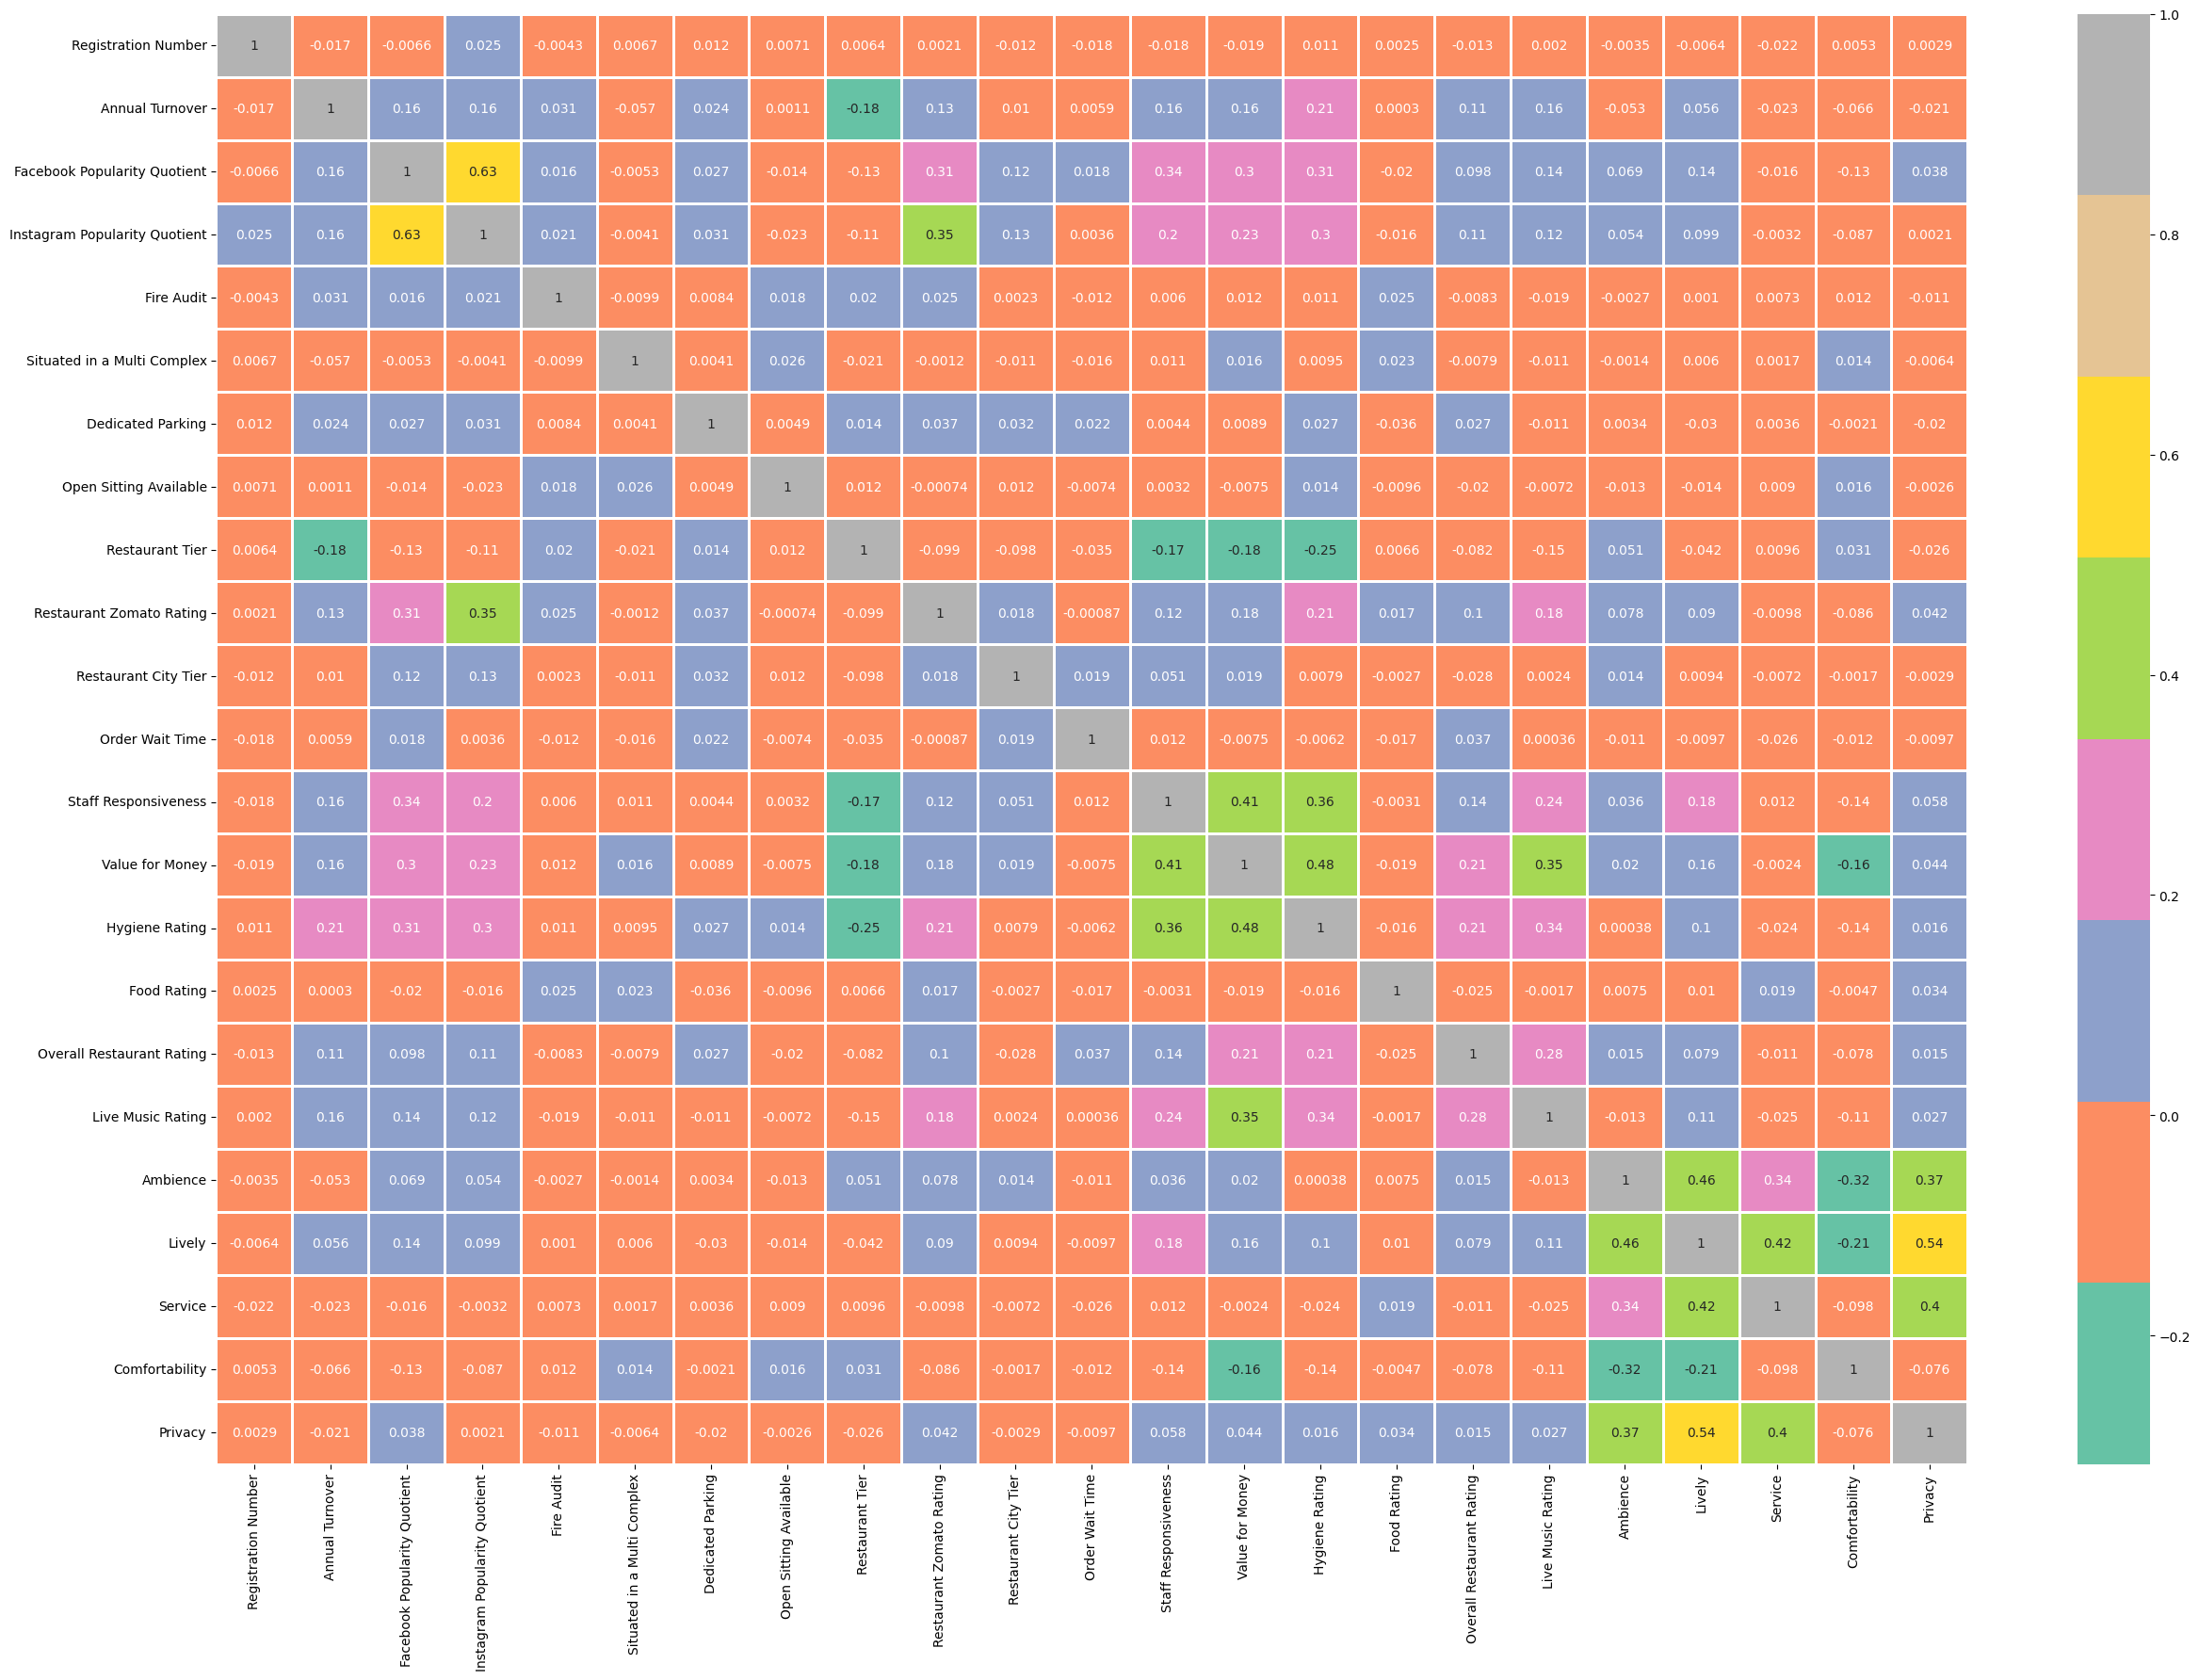

In [753]:
plt.figure(figsize=(30,20))
sns.heatmap(rest_df.select_dtypes(include=np.number).corr(),annot=True,cmap='Set2',linewidths=1);

### Key Observations:
1. **Strong Positive Correlations**:
   - Features like **Annual Turnover**, **Facebook Popularity Quotient**, and **Instagram Popularity Quotient** are strongly correlated, suggesting that social media engagement is a significant driver of revenue.
   - **Value for Money** and **Hygiene Rating** have a strong positive correlation, indicating that customers often associate value with cleanliness.

2. **Weak or No Correlations**:
   - Some features, like **Registration Number**, show weak or no correlation with other variables, as they may not influence the dependent variables significantly.

3. **Negative Correlations**:
   - There is some negative correlation between **Hygiene Rating** and **Restaurant Tier**, suggesting that high-tier restaurants may need to focus more on hygiene perceptions.

### Insights:
- Social media presence plays a critical role in increasing turnover.
- Staff responsiveness,value for money,hygine ratings,Zoato ratings and live music rating has impact on turn over as well
- Customer satisfaction (e.g., hygiene, value for money) is interconnected and impacts overall restaurant ratings.
- Identifying and leveraging highly correlated features can improve predictive modeling.


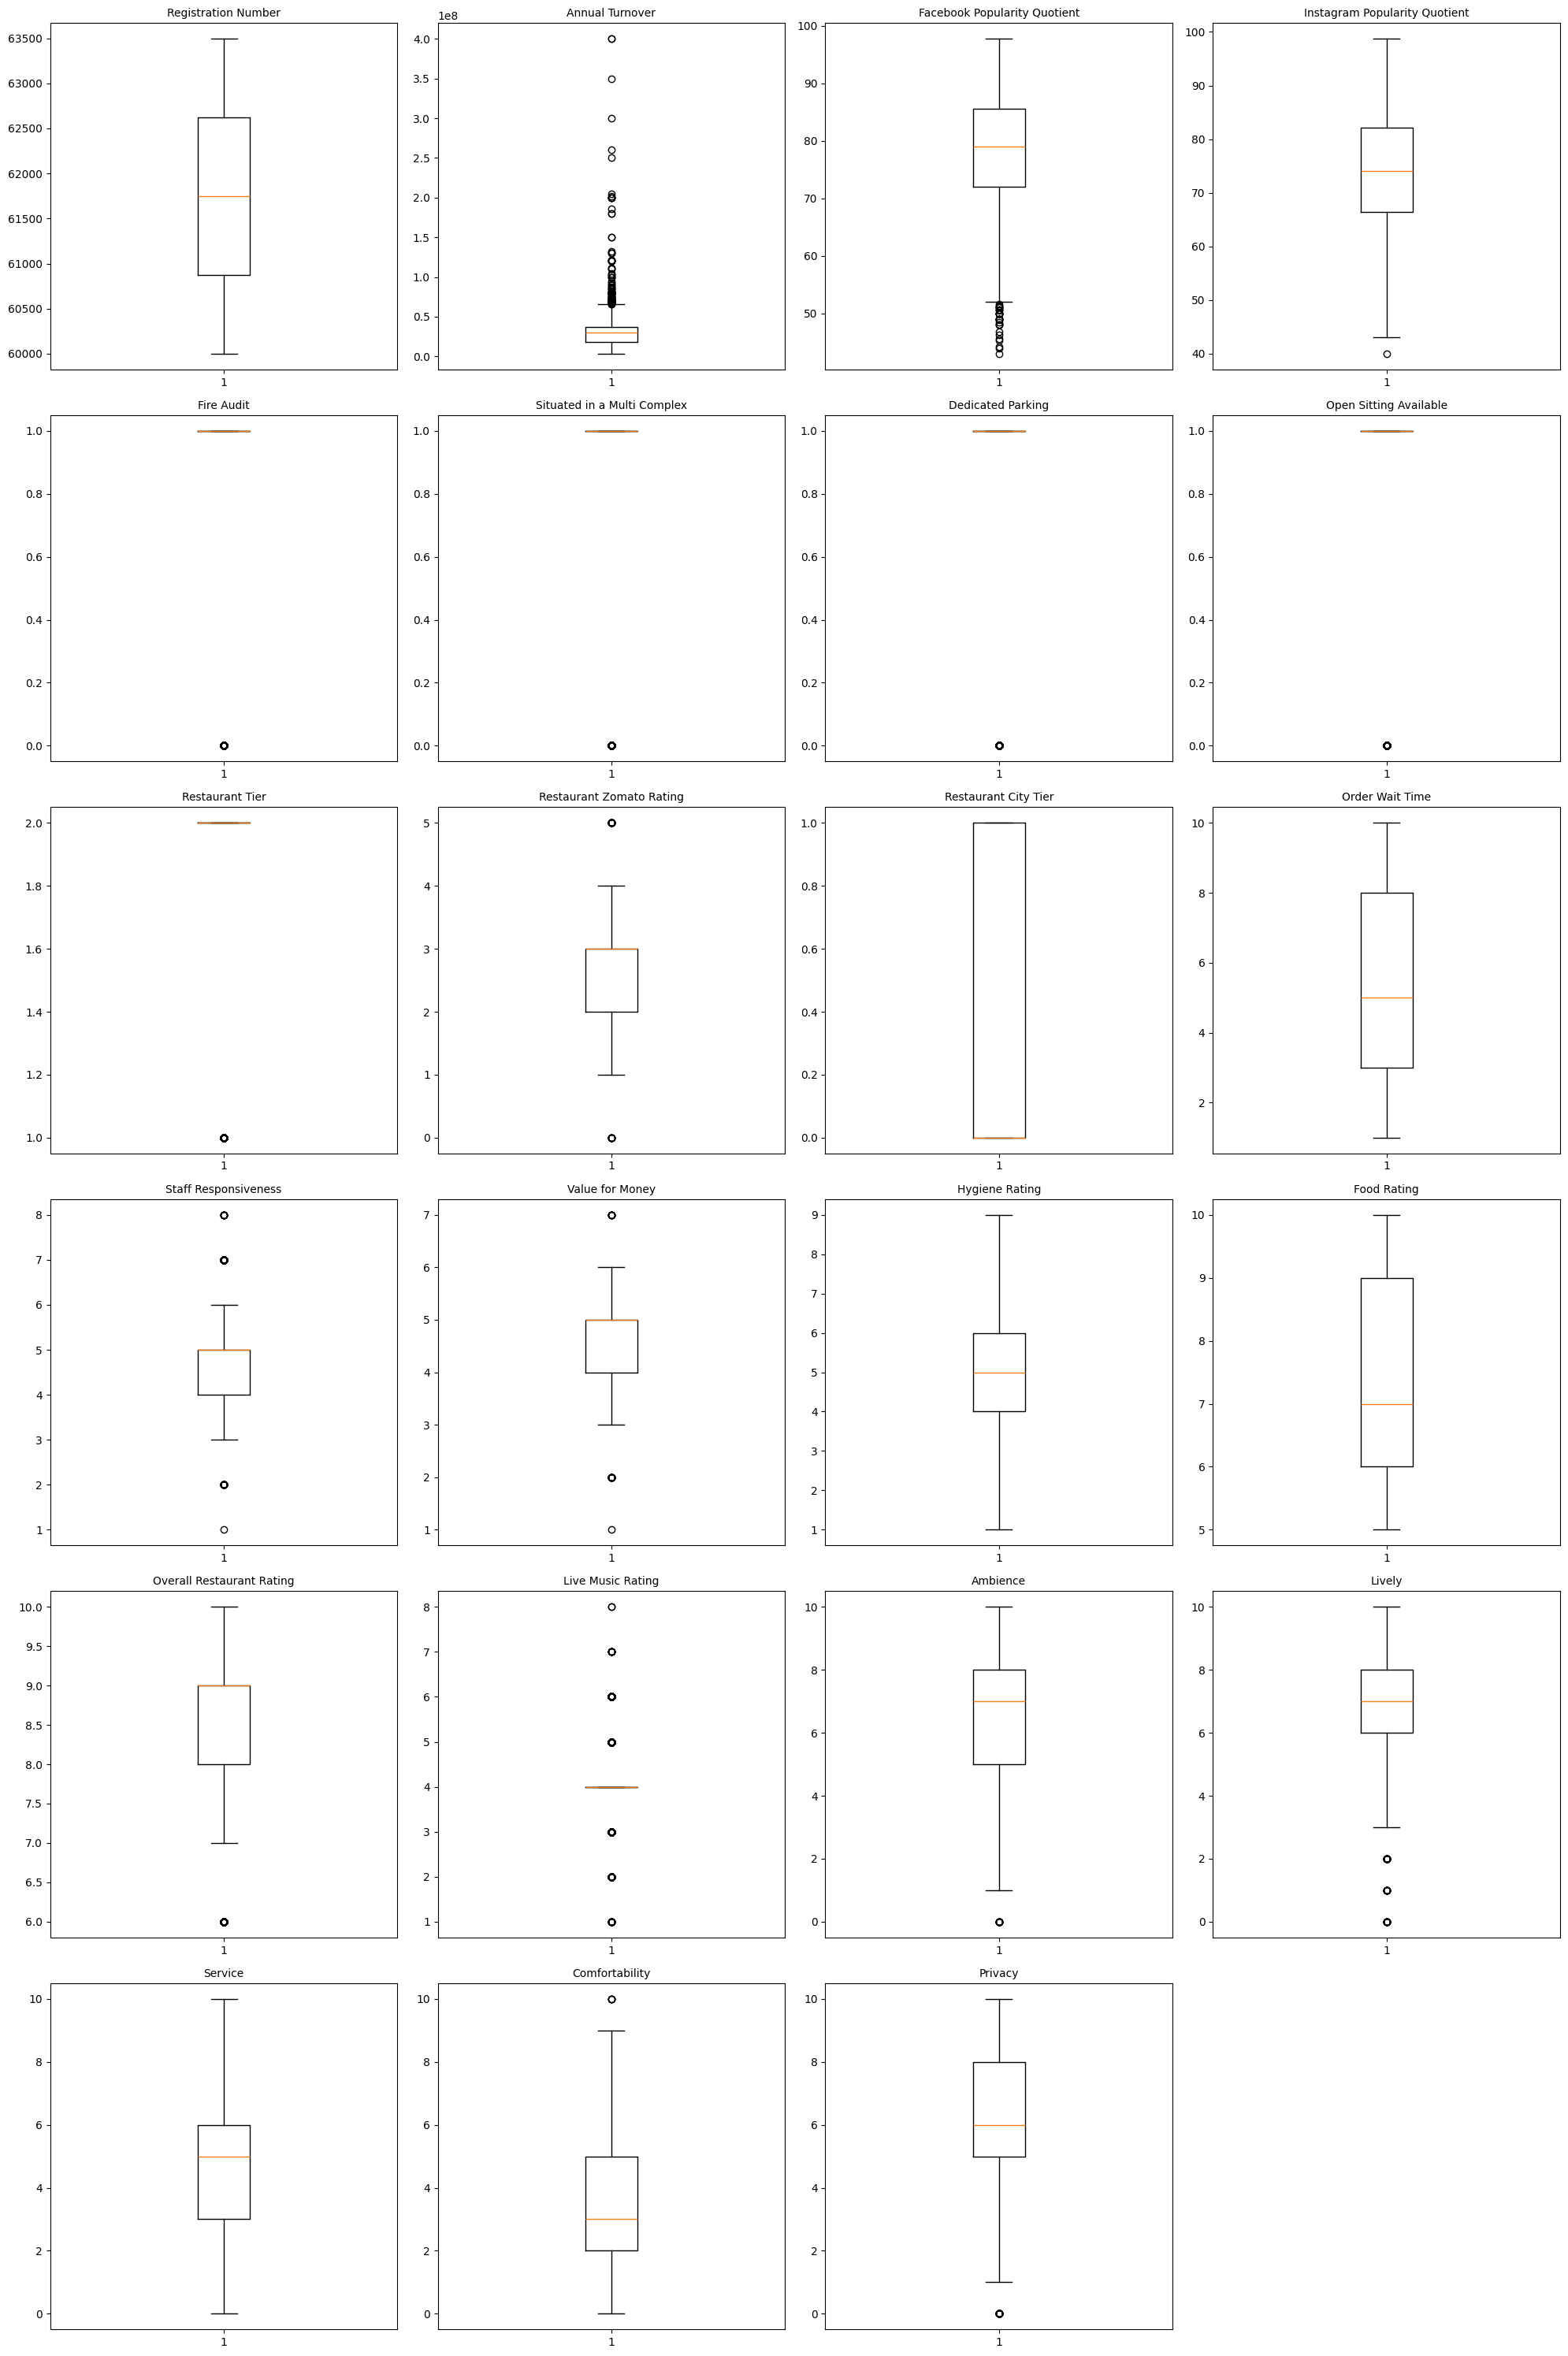

In [754]:
# Select numerical columns
numerical_col = rest_df.select_dtypes(include=np.number).columns.tolist()
num_columns = len(numerical_col)

# Calculate grid size
rows = (num_columns // 4) + (num_columns % 4 > 0)  # 4 subplots per row
cols = 4  # Fixed number of columns

# Set the figure size
plt.figure(figsize=(5 * cols, 5 * rows))  # Adjust figure size dynamically

# Plot boxplots for each numerical column
for i, variable in enumerate(numerical_col):
    plt.subplot(rows, cols, i + 1)  # Ensure subplot numbering starts from 1
    plt.boxplot(rest_df[variable].dropna(), whis=1.5)  # Handle NaN values
    plt.title(variable, fontsize=10)

# Prevent overlapping of plots
plt.tight_layout()

# Display the plots
plt.show()

There are some outliers and even anualturnover max value is quite high as well.we will treat Those

In [755]:
# drop registration Number
rest_df.drop(columns=['Registration Number'],inplace=True)

In [756]:
# function to check for outlier
def check_outliers(data, feature):
  """function to check for outliers in feature"""
  Q1 = data[feature].quantile(0.25)
  Q3 = data[feature].quantile(0.75)

  IQR = Q3 - Q1                   #Inter Quantile Range
  lower_whisker = Q1 - 1.5*IQR    #lower whisker
  upper_whisker = Q3 + 1.5*IQR    #upper whisker

  #calculate percentage of outliers
  print(f"Percentage of outliers in {feature}: ", round(((data[feature] < lower_whisker) | (data[feature] > upper_whisker)).sum()/data.shape[0]*100,2))

In [757]:
#select numerical columns except Registration Number
numerical_columns=rest_df.select_dtypes(include="number").columns.tolist()

#check outliers for all numerical columns
for col in numerical_columns:
  check_outliers(rest_df, col)

Percentage of outliers in Annual Turnover:  2.72
Percentage of outliers in Facebook Popularity Quotient:  0.92
Percentage of outliers in Instagram Popularity Quotient:  0.03
Percentage of outliers in Fire Audit:  21.13
Percentage of outliers in Situated in a Multi Complex:  19.18
Percentage of outliers in Dedicated Parking:  19.81
Percentage of outliers in Open Sitting Available:  19.98
Percentage of outliers in Restaurant Tier:  7.24
Percentage of outliers in Restaurant Zomato Rating:  1.46
Percentage of outliers in Restaurant City Tier:  0.0
Percentage of outliers in Order Wait Time:  0.0
Percentage of outliers in Staff Responsiveness:  5.21
Percentage of outliers in Value for Money:  1.4
Percentage of outliers in Hygiene Rating:  0.0
Percentage of outliers in Food Rating:  0.0
Percentage of outliers in Overall Restaurant Rating:  8.25
Percentage of outliers in Live Music Rating:  46.32
Percentage of outliers in Ambience:  0.6
Percentage of outliers in Lively:  2.43
Percentage of out

In [758]:
def treat_outliers(df, col):
    """
    Treats outliers in a variable

    df: dataframe
    col: dataframe column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker
    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df


def treat_outliers_all(df, col_list):
    """
    Treat outliers in a list of variables

    df: dataframe
    col_list: list of dataframe columns
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df

In [759]:
binomial_cols=["Fire Audit","Liquor License Obtained","Situated in a Multi Complex","Dedicated Parking",
"Open Sitting Available","Restaurant Tier",'Restaurant City Tier']

In [760]:
#Outlier Treatment
numerical_cols = [col for col in rest_df.select_dtypes(include=np.number).columns.tolist() if col not in binomial_cols]
print(numerical_cols)
rest_df = treat_outliers_all(rest_df, numerical_cols)

['Annual Turnover', 'Facebook Popularity Quotient', 'Instagram Popularity Quotient', 'Restaurant Zomato Rating', 'Order Wait Time', 'Staff Responsiveness', 'Value for Money', 'Hygiene Rating', 'Food Rating', 'Overall Restaurant Rating', 'Live Music Rating', 'Ambience', 'Lively', 'Service', 'Comfortability', 'Privacy']


In [761]:
rest_df.columns

Index(['Annual Turnover', 'Cuisine', 'City', 'Restaurant Location',
       'Opening Day of Restaurant', 'Facebook Popularity Quotient',
       'Endorsed By', 'Instagram Popularity Quotient', 'Fire Audit',
       'Situated in a Multi Complex', 'Dedicated Parking',
       'Open Sitting Available', 'Restaurant Tier', 'Restaurant Type',
       'Restaurant Theme', 'Restaurant Zomato Rating', 'Restaurant City Tier',
       'Order Wait Time', 'Staff Responsiveness', 'Value for Money',
       'Hygiene Rating', 'Food Rating', 'Overall Restaurant Rating',
       'Live Music Rating', 'Ambience', 'Lively', 'Service', 'Comfortability',
       'Privacy'],
      dtype='object')

In [762]:
rest_df.head(5)

,Annual Turnover,Cuisine,City,Restaurant Location,Opening Day of Restaurant,Facebook Popularity Quotient,Endorsed By,Instagram Popularity Quotient,Fire Audit,Situated in a Multi Complex,...,Value for Money,Hygiene Rating,Food Rating,Overall Restaurant Rating,Live Music Rating,Ambience,Lively,Service,Comfortability,Privacy
0,42000000,"indian,irish",Bangalore,Near Business Hub,14/02/09,84.30,Not Specific,95.80,1,1,...,5.00,5,7,10.00,4.00,8.00,8,6,6.00,6.00
1,50000000,"indian,irish",Others,Near Party Hub,29/09/08,85.40,Tier A Celebrity,85.00,1,1,...,6.00,7,8,9.00,4.00,5.00,7,7,3.00,8.00
2,32500000,"tibetan,italian",Chennai,Near Business Hub,30/07/11,85.00,Tier A Celebrity,68.20,1,1,...,5.00,3,7,8.00,4.00,7.00,10,5,2.00,8.00
3,65500000,"turkish,nigerian",Gurgaon,Near Party Hub,30/11/08,85.60,Tier A Celebrity,83.60,0,1,...,5.00,6,8,9.00,4.00,7.00,7,4,3.00,5.00
4,20000000,Others,Others,Near Party Hub,22/02/10,79.00,Tier A Celebrity,76.80,1,1,...,6.00,4,8,6.50,4.00,7.00,6,2,4.00,6.00


In [763]:
rest_df['Opening Day of Restaurant'] = pd.to_datetime(rest_df['Opening Day of Restaurant'], format='%d/%m/%y', errors='coerce')
rest_df['Years Since Opening'] = round((pd.to_datetime('today') - rest_df['Opening Day of Restaurant']).dt.days / 365.25,2)
rest_df.drop(columns=['Opening Day of Restaurant'],inplace=True)

In [764]:
#transforming independent variables
# rest_df['Restaurant Tier'] = np.sqrt(rest_df['Restaurant Tier'])
# rest_df['Restaurant City Tier'] = np.sqrt(rest_df['Restaurant City Tier'])

In [765]:
#transforming independent variables
test_df['Opening Day of Restaurant'] = pd.to_datetime(test_df['Opening Day of Restaurant'], format='%d/%m/%y', errors='coerce')
test_df['Years Since Opening'] = round((pd.to_datetime('today') - test_df['Opening Day of Restaurant']).dt.days / 365.25,2)
test_df.drop(columns=['Opening Day of Restaurant'],inplace=True)
# test_df['Restaurant Tier'] = np.sqrt(test_df['Restaurant Tier'])
# test_df['Restaurant City Tier'] = np.sqrt(test_df['Restaurant City Tier'])

In [766]:
df=rest_df.copy(deep=True)

In [767]:
test_df.columns

Index(['Registration Number', 'Cuisine', 'City', 'Restaurant Location',
       'Facebook Popularity Quotient', 'Endorsed By',
       'Instagram Popularity Quotient', 'Fire Audit',
       'Liquor License Obtained', 'Situated in a Multi Complex',
       'Dedicated Parking', 'Open Sitting Available', 'Restaurant Tier',
       'Restaurant Type', 'Restaurant Theme', 'Restaurant Zomato Rating',
       'Restaurant City Tier', 'Order Wait Time', 'Staff Responsiveness',
       'Value for Money', 'Hygiene Rating', 'Food Rating',
       'Overall Restaurant Rating', 'Live Music Rating', 'Comedy Gigs Rating',
       'Value Deals Rating', 'Live Sports Rating', 'Ambience', 'Lively',
       'Service', 'Comfortability', 'Privacy', 'Years Since Opening'],
      dtype='object')

In [768]:
# map_c={}
# c=1
# for i in cuisine_df.index:
#     map_c[i]=c
#     c=c+1
# print(map_c)

In [769]:
# df['Cuisine']=df['Cuisine'].map(map_c)
# test_df['Cuisine']=test_df['Cuisine'].map(map_c)

In [770]:
# theme_df=df.groupby(['Restaurant Theme'])[['Annual Turnover']].mean().sort_values('Annual Turnover',ascending=False)
# theme_df

In [771]:
# map_t={}
# c=1
# for i in theme_df.index:
#     map_t[i]=c
#     c=c+1
# print(map_t)

In [772]:
# df['Restaurant Theme']=df['Restaurant Theme'].map(map_t)
# test_df['Restaurant Theme']=df['Restaurant Theme'].map(map_t)


In [773]:
# city=df.groupby(['City'])[['Annual Turnover']].mean().sort_values('Annual Turnover',ascending=False)
# map_ct={}
# c=1
# for i in city.index:
#     map_ct[i]=c
#     c=c+1
# print(map_ct)

In [774]:
# df['City']=df['City'].map(map_ct)
# test_df['City']=test_df['City'].map(map_ct)
# df.drop(columns=['City'],inplace=True)
# test_df.drop(columns=['City'],inplace=True)

In [775]:
X = df.drop('Annual Turnover', axis=1)
y = df['Annual Turnover']
X_test = test_df.drop(["Registration Number"], axis=1).copy(deep=True)


In [776]:
X.select_dtypes(include=["object", "category"]).columns.tolist()

['Cuisine',
 'City',
 'Restaurant Location',
 'Endorsed By',
 'Restaurant Type',
 'Restaurant Theme']

In [777]:
X = pd.get_dummies(
    X,
    columns=X.select_dtypes(include=["object", "category"]).columns.tolist(),
    drop_first=True,
)

# specifying the datatype of the independent variables dataframe
X = X.astype(float)

In [778]:
X_test = pd.get_dummies(
    X_test,
    columns=X_test.select_dtypes(include=["object", "category"]).columns.tolist(),
    drop_first=True,
)

# specifying the datatype of the independent variables dataframe
X_test = X_test.astype(float)

In [779]:
scaler = StandardScaler()
X[X.select_dtypes(include='number').columns.tolist()] = scaler.fit_transform(X[X.select_dtypes(include='number').columns.tolist()])

In [780]:
scaler = StandardScaler()
X_test[X_test.select_dtypes(include='number').columns.tolist()] = scaler.fit_transform(X_test[X_test.select_dtypes(include='number').columns.tolist()])

In [781]:
# Combine normalized Facebook Popularity Quotient and Instagram Popularity Quotient into one variable
X['Media Popularity'] = (X['Facebook Popularity Quotient'] + X['Instagram Popularity Quotient'])/2
# Drop the original Facebook Popularity Quotient and Instagram Popularity Quotient columns
X = X.drop(['Facebook Popularity Quotient', 'Instagram Popularity Quotient'], axis=1)


# Combine normalized Facebook Popularity Quotient and Instagram Popularity Quotient into one variable
X['Restaurant City Level'] = (X['Restaurant Tier'] + X['Restaurant City Tier']) / 2

# Drop the original Facebook Popularity Quotient and Instagram Popularity Quotient columns
X = X.drop(['Restaurant Tier', 'Restaurant City Tier'], axis=1)

In [782]:
# Combine normalized Facebook Popularity Quotient and Instagram Popularity Quotient into one variable
X_test['Media Popularity'] = (X_test['Facebook Popularity Quotient'] + X_test['Instagram Popularity Quotient'])/2
# Drop the original Facebook Popularity Quotient and Instagram Popularity Quotient columns
X_test = X_test.drop(['Facebook Popularity Quotient', 'Instagram Popularity Quotient'], axis=1)


# Combine normalized Facebook Popularity Quotient and Instagram Popularity Quotient into one variable
X_test['Restaurant City Level'] = (X_test['Restaurant Tier'] + X_test['Restaurant City Tier']) / 2

# Drop the original Facebook Popularity Quotient and Instagram Popularity Quotient columns
X_test = X_test.drop(['Restaurant Tier', 'Restaurant City Tier'], axis=1)

In [783]:
x_train=X.copy(deep=True)
y_train=y.copy(deep=True)
x_test=X_test.copy(deep=True)

In [784]:
print(x_train.shape,y_train.shape,x_test.shape)

(3493, 56) (3493,) (500, 60)


In [785]:
#
y_train = np.logp(y_train)


In [604]:
olsmod = sm.OLS(y_train, x_train)
olsres = olsmod.fit()

# let's print the regression summary
print(olsres.summary())


                                 OLS Regression Results                                
Dep. Variable:        Annual Turnover   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.016
Method:                 Least Squares   F-statistic:                            0.01738
Date:                Sun, 24 Nov 2024   Prob (F-statistic):                        1.00
Time:                        03:12:49   Log-Likelihood:                         -14870.
No. Observations:                3493   AIC:                                  2.985e+04
Df Residuals:                    3436   BIC:                                  3.020e+04
Df Model:                          57                                                  
Covariance Type:            nonrobust                                                  
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------

In [605]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [606]:
vif_df=calculate_vif(x_train)


In [607]:
vif_df[vif_df['VIF']>5]

,Feature,VIF
46,Endorsed By_Not Specific,28.04
47,Endorsed By_Tier A Celebrity,28.29


In [621]:
mode_lin=LinearRegression()
mode_lin.fit(x_train,axis=1),y_train)
mode_lin.score(x_train,y_train)

KeyError: "['Endorsed By_Not Specific', 'Endorsed By_Tier A Celebrity'] not found in axis"

In [613]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

rf = RandomForestRegressor(random_state=42)
rf.fit(x_train, y_train)

feature_importance = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Select top 50 features based on importance
top_features = feature_importance.head(20)['Feature'].tolist()
x_train_selected = x_train[top_features]

In [614]:
rf.fit(x_train_selected, y_train)
train_score = rf.score(x_train_selected, y_train)
print(f"Training R² Score: {train_score}")

Training R² Score: 0.8909942157768032


In [612]:
X_test['Media Popularity']

,Media Popularity
0,-0.23
1,1.52
2,0.82
3,0.08
4,0.87
...,...
495,-0.40
496,-0.90
497,-0.39
498,1.72


In [616]:
# Make predictions on the test set using the trained model
y_test_pred = rf.predict(X_test[top_features])

# Convert the predictions back to the original scale (if needed)
y_test_pred = np.expm1(y_test_pred)

# Create a DataFrame with the Registration Number and predicted Annual Turnover values
results = pd.DataFrame({"Registration Number": test_df["Registration Number"], "Annual Turnover": y_test_pred})

# Convert the Annual Turnover column to integers
results["Annual Turnover"] = results["Annual Turnover"].astype(int)

# Set the Registration Number column as the index
results.set_index("Registration Number", inplace=True)

# Export the results as a CSV file
results.to_csv("prediction_rf.csv")

In [727]:
results

,Annual Turnover
Registration Number,
20001,23011740
20002,27035517
20003,26783474
20004,42030104
20005,39278914
...,...
20496,28552762
20497,22454885
20498,29429017
